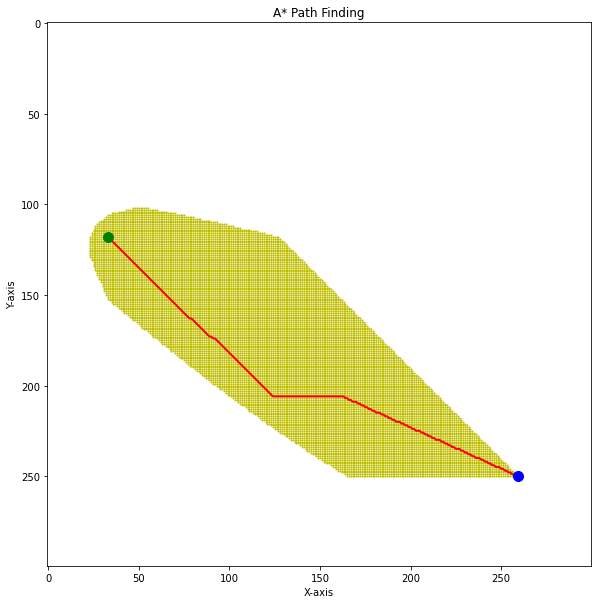

len path :  227
cell added (space):  [205 192]
cell added (space):  [360 222]
65[array([ 51, 110]), array([205, 192]), array([360, 222]), array([401, 234])]
IN: d= 742.8657589060439  angle= 41.757924580030284
omega =  0.2915253090883995
after omega: w_ml, w_mr :  2.351323356435748 1.1038662198714335
v_ml :  252.7672608168429 v_mr :  118.6656186361791
v_m =  {'motor.left.target': [252], 'motor.right.target': [118]}
IN: d= 736.7074582279587  angle= 38.65861615912086
omega =  0.26988805449653724
after omega: w_ml, w_mr :  2.2907080659645884 1.1358382513747542
v_ml :  246.25111709119327 v_mr :  122.10261202278608
v_m =  {'motor.left.target': [246], 'motor.right.target': [122]}
IN: d= 726.7642764126045  angle= 36.00852234519871
omega =  0.25138690948066705
after omega: w_ml, w_mr :  2.2280005421739957 1.15229841788463
v_ml :  239.51005828370452 v_mr :  123.87207992259773
v_m =  {'motor.left.target': [239], 'motor.right.target': [123]}
IN: d= 716.3972558206464  angle= 32.17485934422021
omega

In [ ]:
%reload_ext autoreload
%autoreload 2

import numpy as np
import cv2
from tdmclient import ClientAsync, aw
from final_camera_class import *
from final_Thymio_class import *
from final_path import *
from motion import *

###########################################################
#Parameters
###########################################################
camera_index=1 #0 if no webcam
corner_aruco_id=[0, 1, 2, 10] #top-left, bottom-left, bottom-right, top-right
corner_aruco_size=65 #mm
min_size=500 #minimum blob size
thresh_obstacle=np.array([[40,20,120,65,50,160]]) #BGR
thresh_goal=np.array([40,40,20,60,150,65]) #BGR
Thymio_id=9
grid_size=300 #blocks? TBD numbers of blocks or pixels?
ANGLE_THRESHOLD = np.radians(40)   #threshold under which changes of directions are ignored [rad]
STEP = 10                           #step (in number of cells) between each cell we study
COUNTER_THRESHOLD = 10              #max number of steps between keypoints
keypoint_dist_thresh=1 #pix TBD

###########################################################
#Main Code
###########################################################
from tdmclient import ClientAsync, aw
client = ClientAsync()
node = await client.wait_for_node()
aw(node.lock())

async def main():
    
    #Camera initialization
    cam=camera_class(camera_index,corner_aruco_id,corner_aruco_size,min_size, thresh_obstacle, thresh_goal)

    #Thymio initialization
    Thymio=Thymio_class(Thymio_id,cam.persp_image)


    Path_planning=True #We want to have the path
    step = 0
    
    while True :
        step = step + 1
        #Update Image
        cam.get_image()
        cam.correct_perspective_aruco(get_matrix=False)
        #Path Planning
        if Path_planning:
            if Thymio.target_keypoint==None: #only possible at first iteration to not take time later
                do_plot=True
            grid=discretize_image_eff(cam.thresholded_image,grid_size)
            #Careful! Image frame's first coord (x) is pointing right but in a matrix the first coordinate (rows) is pointing down so they must be inverted
            path, _, _ = a_star_search(grid, grid1_coord2grid2_coord(np.array([Thymio.xytheta_est[1],Thymio.xytheta_est[0]]),cam.persp_image,grid), grid1_coord2grid2_coord(np.array([cam.goal_center[1],cam.goal_center[0]]),cam.persp_image,grid),do_plot)

            # Convert path coordinates for plotting
            path_img = grid1_coord2grid2_coord(path, grid, cam.persp_image)
            path_img = path_img[::-1]
            
            keypoints=find_keypoints(path_img,ANGLE_THRESHOLD,STEP,COUNTER_THRESHOLD)
            print(f"65{keypoints}")
            #keypoints=keypoints[np.linalg.norm(keypoints-Thymio.xytheta_est[:2].reshape(2,1),axis=1)<keypoint_dist_thresh,:] #Keep only far keypoints
            #print(f"67{keypoints}")
            #Thymio.target_keypoint=Thymio.keypoints[0,:]
            #Thymio.keypoints=keypoints[1:,:]
            do_plot=False
            Path_planning=False

        #Thymio Position and motor 
        Thymio.Thymio_position_aruco(cam.persp_image)
        Thymio.delta_time_update()
        #TBD await get motor speed something
        if((step % 5)==0) :
            x_mm, y_mm, theta_rad, x_goal_mm, y_goal_mm = adjust_units(Thymio.xytheta_meas, Thymio.target_keypoint, cam.pixbymm)
            v_m = motion_control(x_mm, y_mm, theta_rad, x_goal_mm, y_goal_mm)
            print ("v_m = ", v_m)
            await node.set_variables(v_m)
            draw_on_image(cam,Thymio,path_img)
            
            

#         if Thymio.Thymio_detected:
#             #TBD Thymio.kalmanfilter_detected don't forget variance of kalman filter in plot!!
#             pass
#         else:
#             #TBD Thymio.kalmanfilter_not_detected
#             pass

#         #Obstacle detection
#         #TBD await get oprox sensor data
#         obstacle=False #TBD
#         if obstacle:
#             Thymio.local_avoidance=True
#             #TBD Thymio.local avoidance to update target motor speed
#             #TBD await set speed (thymio.speed)
#             draw_on_image(cam,Thymio,path_img)
#             continue
#         else:
#             if Thymio.local_avoidance:
#                 Path_planning=True
#                 draw_on_image(cam,Thymio,path_img)
#                 continue
#         #Target Achieved?
#             else:
#                 if np.linalg.norm(Thymio.xytheta_est[:2]-Thymio.target_keypoint)<keypoint_dist_thresh:
#                     if Thymio.keypoints.size==0:
#                         print("Goal Achieved!")
#                         break
#                     else: #Update target
#                         Thymio.target_keypoint=Thymio.keypoints[0,:]
#                         Thymio.keypoints=Thymio.keypoints[1:,:]
#                 #Controller:
#                 #TBD Thymio.astolfi get speed and set them
#                 draw_on_image(cam,Thymio,path_img)
    # cam.cam.release()
    # cv2.destroyAllWindows()

# Run the main asynchronous function
client.run_async_program(main)
aw(node.stop())
aw(node.unlock())

In [ ]:
# Stop the program
aw(node.stop())
aw(node.unlock())

In [ ]:
cam.cam.release()

In [1]:
from tdmclient import ClientAsync, aw
client = ClientAsync()
node = await client.wait_for_node()
aw(node.lock())

# Stop the program
aw(node.stop())
aw(node.unlock())